In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm.contrib.concurrent import process_map

import illustris_python as il

In [2]:
with np.load("halo_data.npz") as data:
    time = data["TNGtime"]
    redshift = data["TNGredshift"]

In [3]:
# load data
with np.load("history_data.npz") as data:
    halo_mass = data["Mh"]
    stellar_mass = data["Ms"]
    gas_mass = data["Mg"]

Now we will split up the galaxy sample into 4 equally populated samples between the mass ranges $\log_{10}M_h=11$ and $\log_{10}M_h=12$ (at redshift 0).

In [4]:
mass_lower_bound = 11
mass_upper_bound = 12.5

mass_range = (halo_mass[:,-1] > mass_lower_bound) * (halo_mass[:,-1] < mass_upper_bound)
print(halo_mass[mass_range].shape)

quartiles = np.percentile(halo_mass[mass_range,-1], [25, 50, 75])

first_quartile = (halo_mass[:,-1] > mass_lower_bound) * (halo_mass[:,-1] < quartiles[0])
second_quartile = (halo_mass[:,-1] > quartiles[0]) * (halo_mass[:,-1] < quartiles[1])
third_quartile = (halo_mass[:,-1] > quartiles[1]) * (halo_mass[:,-1] < quartiles[2])
fourth_quartile = (halo_mass[:,-1] > quartiles[2]) * (halo_mass[:,-1] < mass_upper_bound)

print(halo_mass[first_quartile].shape, halo_mass[second_quartile].shape, halo_mass[third_quartile].shape, halo_mass[fourth_quartile].shape)

quartile_filters = [first_quartile, second_quartile, third_quartile, fourth_quartile]
bounds = [mass_lower_bound, *quartiles, mass_upper_bound]

(14023, 100)
(3506, 100) (3505, 100) (3505, 100) (3506, 100)


Now we create filters for selecting galaxies by the residual from the median stellar mass (1 sigma and 2 sigma).

We then calculate the median stellar mass in each filter at each timestep and plot the efficiency at each timestep.

$\varepsilon_B=\frac{M_*}{M_*+M_g}$

In [5]:
medians = np.ndarray(4)
sigmas = np.ndarray(4)
sigma_filters = []

styles = ["-", "--", ":", "-", "--", ":"]

for i, quartile in enumerate(quartile_filters):
    sigma_filter = []
    
    medians[i] = np.median(stellar_mass[quartile, -1])
    sigmas[i] = np.std(stellar_mass[quartile, -1])
    
    sigma_filter.append((stellar_mass[quartile, -1] > medians[i]) * (stellar_mass[quartile, -1] < medians[i] + sigmas[i]))
    sigma_filter.append((stellar_mass[quartile, -1] > medians[i] + sigmas[i]) * (stellar_mass[quartile, -1] < medians[i] + 2*sigmas[i]))
    sigma_filter.append((stellar_mass[quartile, -1] > medians[i] + 2*sigmas[i]) * (stellar_mass[quartile, -1] < medians[i] + 3*sigmas[i]))
    sigma_filter.append((stellar_mass[quartile, -1] < medians[i]) * (stellar_mass[quartile, -1] > medians[i] - sigmas[i]))
    sigma_filter.append((stellar_mass[quartile, -1] < medians[i] - sigmas[i]) * (stellar_mass[quartile, -1] > medians[i] - 2*sigmas[i]))
    sigma_filter.append((stellar_mass[quartile, -1] < medians[i] - 2*sigmas[i]) * (stellar_mass[quartile, -1] > medians[i] - 3*sigmas[i]))
    
    sigma_filters.append(sigma_filter)

In [6]:
inflection_points = [[], [], [], [2.3, 3.5, 8.9]]  # [Gyr]

In [7]:
efficiency = np.ndarray((4, 6, 100))

for i, quartile in enumerate(quartile_filters):
    for j, sig_filter in enumerate(sigma_filters[i]):
        for k in range(100):
            stars = np.nanmedian(stellar_mass[quartile, k][sig_filter])
            gas = np.nanmedian(gas_mass[quartile, k][sig_filter])
            efficiency[i, j, k] = 10**stars / (10**stars + 10**gas)

/opt/conda/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


Text(0.5,0,'Age of the Universe [Gyr]')

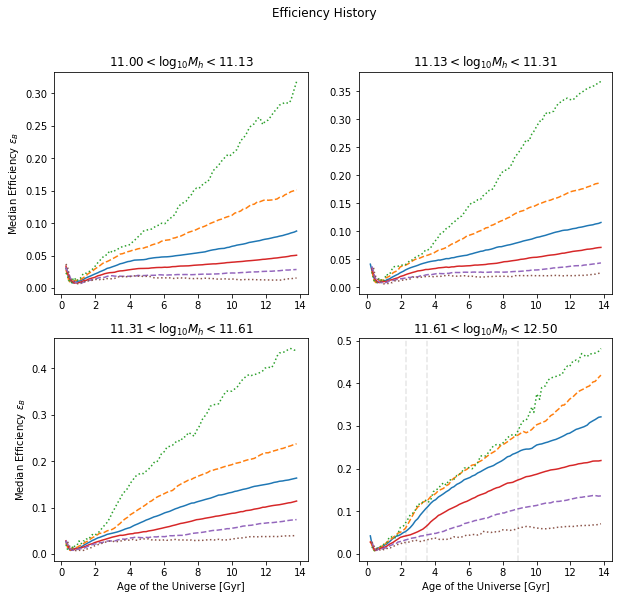

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(10, 9))
axes = axes.flatten()

for i in range(4):
    for point in inflection_points[i]:
        axes[i].axvline(point, ls="--", c="0.9")
    
    axes[i].set_title(f"${bounds[i]:.2f}<\log_{{10}}M_h<{bounds[i+1]:.2f}$")
    for j in range(6):
        axes[i].plot(time, efficiency[i, j], linestyle=styles[j])

fig.suptitle("Efficiency History")
axes[0].set_ylabel("Median Efficiency $\\varepsilon_B$")
axes[2].set_ylabel("Median Efficiency $\\varepsilon_B$")
axes[2].set_xlabel("Age of the Universe [Gyr]")
axes[3].set_xlabel("Age of the Universe [Gyr]")

# fig.savefig("efficiency_history")

Text(0.5,0,'Age of the Universe [Gyr]')

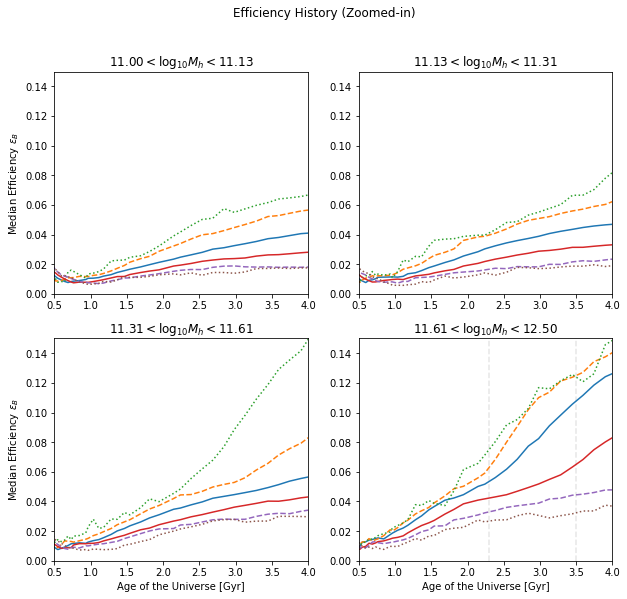

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(10, 9))
axes = axes.flatten()

for i in range(4):
    for point in inflection_points[i]:
        axes[i].axvline(point, ls="--", c="0.9")
    
    axes[i].set_title(f"${bounds[i]:.2f}<\log_{{10}}M_h<{bounds[i+1]:.2f}$")
    axes[i].set_ylim(0, 0.15)
    axes[i].set_xlim(0.5, 4)
    for j in range(6):
        axes[i].plot(time, efficiency[i, j], linestyle=styles[j])

fig.suptitle("Efficiency History (Zoomed-in)")
axes[0].set_ylabel("Median Efficiency $\\varepsilon_B$")
axes[2].set_ylabel("Median Efficiency $\\varepsilon_B$")
axes[2].set_xlabel("Age of the Universe [Gyr]")
axes[3].set_xlabel("Age of the Universe [Gyr]")

# fig.savefig("efficiency_history_zoomed")

We want to plot the medians of some other quantities, number of satellites, black hole luminosity and stellar mass/gas mass.

To do this we need to get the black hole accretion rate and number of satellites from the group catalogues.

I checked the `SubhaloFlag` field but it seemed like the number of subfind halos in the group and the number of subhalos of true cosmological origin are very similar.

In [10]:
# load data
with np.load("additional_data.npz") as data:
    bh_mdot = data["BHMdot"]
    satellites = data["satellites"]

In [11]:
binned_bh_mdot = np.ndarray((4, 6, 100))
binned_satellites = np.ndarray((4, 6, 100))

for i, quartile in enumerate(quartile_filters):
    for j, sig_filter in enumerate(sigma_filters[i]):
        for k in range(100):
            binned_bh_mdot[i, j, k] = np.nanmedian(bh_mdot[quartile, k][sig_filter])
            binned_satellites[i, j, k] = np.nanmedian(satellites[quartile, k][sig_filter])

$L=\frac{\varepsilon_r}{1-\varepsilon_r}\dot{M}_\text{BH}c^2$

In [12]:
e_r = 0.1  # from paper
c = 3e8  # [m/s]
M_sol = 2e30  # [kg]
L_sol = 4e28  # [W]
Gyr = 1e9 * 365 * 24 * 3600  # [s]
conversion = M_sol / (Gyr * L_sol)

luminosity = conversion * e_r / (1 - e_r) * binned_bh_mdot * c**2

Text(0.5,0,'Age of the Universe [Gyr]')

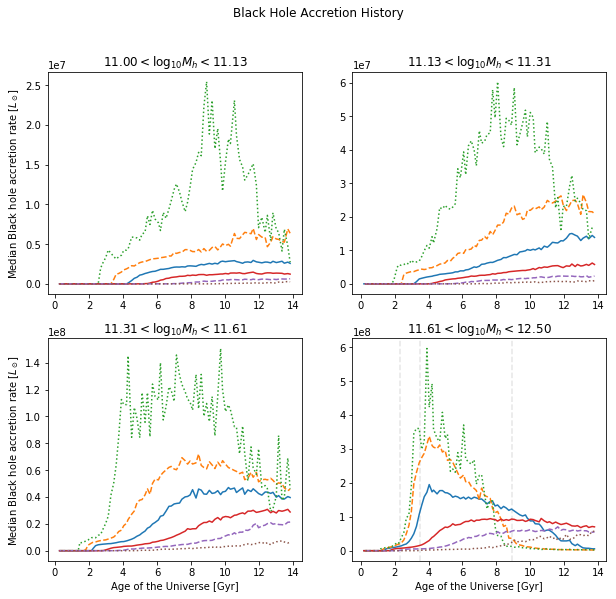

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(10, 9))
axes = axes.flatten()

for i in range(4):
    for point in inflection_points[i]:
        axes[i].axvline(point, ls="--", c="0.9")
        
    axes[i].set_title(f"${bounds[i]:.2f}<\log_{{10}}M_h<{bounds[i+1]:.2f}$")
    for j in range(6):
        axes[i].plot(time, luminosity[i, j], linestyle=styles[j])

fig.suptitle("Black Hole Accretion History")
axes[0].set_ylabel("Median Black hole accretion rate [$L_\\odot$]")
axes[2].set_ylabel("Median Black hole accretion rate [$L_\\odot$]")
axes[2].set_xlabel("Age of the Universe [Gyr]")
axes[3].set_xlabel("Age of the Universe [Gyr]")

Text(0.5,0,'Age of the Universe [Gyr]')

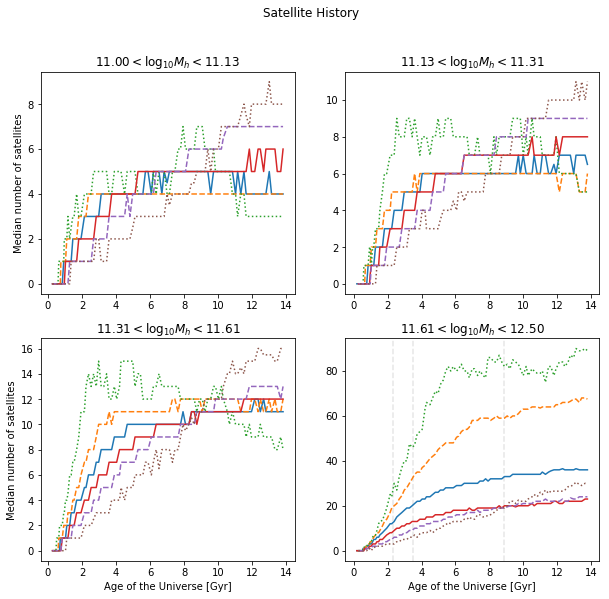

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(10, 9))
axes = axes.flatten()

for i in range(4):
    for point in inflection_points[i]:
        axes[i].axvline(point, ls="--", c="0.9")
    
    axes[i].set_title(f"${bounds[i]:.2f}<\log_{{10}}M_h<{bounds[i+1]:.2f}$")
    for j in range(6):
        axes[i].plot(time, binned_satellites[i, j], linestyle=styles[j])

fig.suptitle("Satellite History")
axes[0].set_ylabel("Median number of satellites")
axes[2].set_ylabel("Median number of satellites")
axes[2].set_xlabel("Age of the Universe [Gyr]")
axes[3].set_xlabel("Age of the Universe [Gyr]")

In [15]:
binned_stellar_mass = np.ndarray((4, 6, 100))
binned_gas_mass = np.ndarray((4, 6, 100))

star_colours = ["dodgerblue", "royalblue", "midnightblue", "dodgerblue", "royalblue", "midnightblue"]
gas_colours = ["red", "firebrick", "maroon", "red", "firebrick", "maroon"]

for i, quartile in enumerate(quartile_filters):
    for j, sig_filter in enumerate(sigma_filters[i]):
        for k in range(100):
            binned_stellar_mass[i, j, k] = np.nanmedian(stellar_mass[quartile, k][sig_filter])
            binned_gas_mass[i, j, k] = np.nanmedian(gas_mass[quartile, k][sig_filter])

Text(0.5,0,'Age of the Universe [Gyr]')

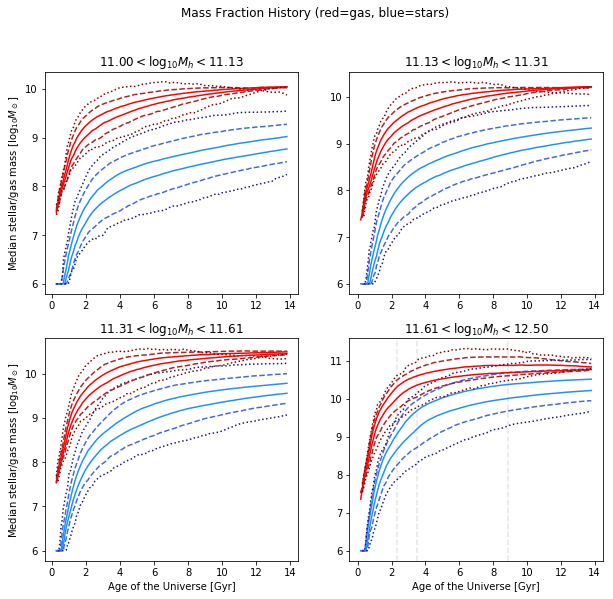

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(10, 9))
axes = axes.flatten()

for i in range(4):
    for point in inflection_points[i]:
        axes[i].axvline(point, ls="--", c="0.9")
        
    axes[i].set_title(f"${bounds[i]:.2f}<\log_{{10}}M_h<{bounds[i+1]:.2f}$")
    for j in range(6):
        axes[i].plot(time, binned_stellar_mass[i, j], linestyle=styles[j], c=star_colours[j])
        axes[i].plot(time, binned_gas_mass[i, j], linestyle=styles[j], c=gas_colours[j])

fig.suptitle("Mass Fraction History (red=gas, blue=stars)")
axes[0].set_ylabel("Median stellar/gas mass [$\\log_{10}M_\\odot$]")
axes[2].set_ylabel("Median stellar/gas mass [$\\log_{10}M_\\odot$]")
axes[2].set_xlabel("Age of the Universe [Gyr]")
axes[3].set_xlabel("Age of the Universe [Gyr]")

# Looking at each halo mass bin individually

Let's look at the bottom left bin individually.

Text(0.5,0,'Age of the Universe [Gyr]')

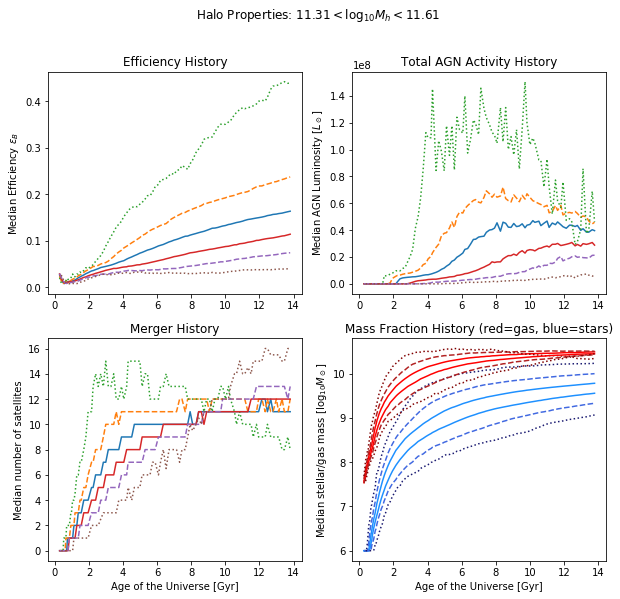

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(10, 9))
axes = axes.flatten()

axes[0].set_title("Efficiency History")
axes[0].set_ylabel("Median Efficiency $\\varepsilon_B$")
for j in range(6):
    axes[0].plot(time, efficiency[2, j], linestyle=styles[j])

axes[1].set_title("Total AGN Activity History")
axes[1].set_ylabel("Median AGN Luminosity [$L_\\odot$]")
for j in range(6):
    axes[1].plot(time, luminosity[2, j], linestyle=styles[j])

axes[2].set_title("Merger History")
axes[2].set_ylabel("Median number of satellites")
for j in range(6):
    axes[2].plot(time, binned_satellites[2, j], linestyle=styles[j])

axes[3].set_title("Mass Fraction History (red=gas, blue=stars)")
axes[3].set_ylabel("Median stellar/gas mass [$\\log_{10}M_\\odot$]")
for j in range(6):
    axes[3].plot(time, binned_stellar_mass[2, j], linestyle=styles[j], c=star_colours[j])
    axes[3].plot(time, binned_gas_mass[2, j], linestyle=styles[j], c=gas_colours[j])
    
fig.suptitle(f"Halo Properties: ${bounds[2]:.2f}<\log_{{10}}M_h<{bounds[3]:.2f}$")
axes[2].set_xlabel("Age of the Universe [Gyr]")
axes[3].set_xlabel("Age of the Universe [Gyr]")